In [ ]:
import pandas as pd
import awkward as ak
import km3io as ki

r = ki.OfflineReader('/Users/meskara/Documents/Energy_Reconstruction/mcv6.4.gsg_nue-NCHEDIS_1e2-1e8GeV.sirene.jterbr00009985.jchain.aanet.253.root')

primary_neutrino_energy = ak.flatten(r[r.mc_tracks.status == 100].mc_tracks.E, axis=1)

df_energy = pd.DataFrame({'Energy': primary_neutrino_energy})

df_energy.to_csv('Primary_Neutrino_Energy.csv', index=False)

print("Filtered energy data saved to 'Primary_Neutrino_Energy.csv'")

Filtered energy data saved to 'Primary_Neutrino_Energy.csv'


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
df_truth = pd.read_csv("/Users/meskara/Documents/Energy_Reconstruction/All_fields_in_one_file.csv")
df_reco = pd.read_csv("/Users/meskara/Documents/Energy_Reconstruction/Primary_Neutrino_Energy.csv")

In [ ]:
df_truth_numeric = df_truth.select_dtypes(include=[np.number])
df_reco_numeric = df_reco.select_dtypes(include=[np.number])

In [7]:
colors_truth = plt.cm.plasma(np.linspace(0, 1, len(df_truth_numeric.columns)))

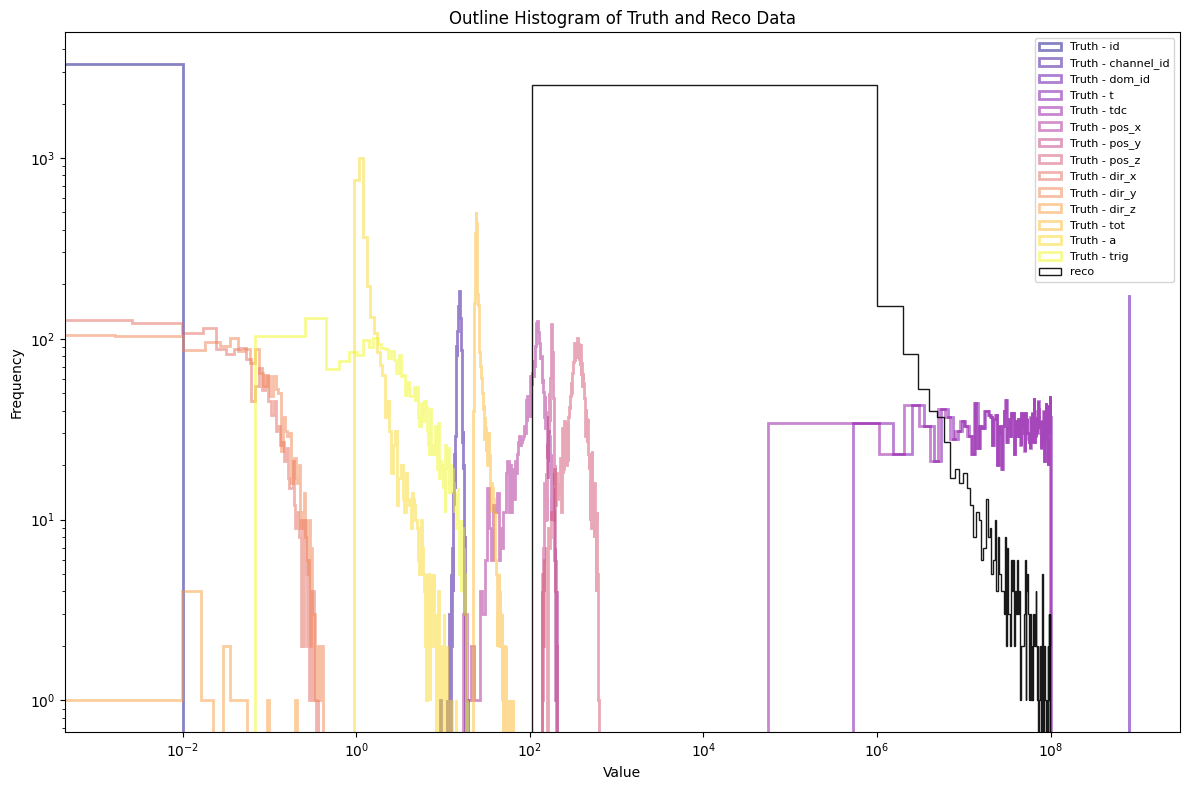

In [ ]:
plt.figure(figsize=(12, 8))

for idx, column in enumerate(df_truth_numeric.columns):
    plt.hist(
        df_truth_numeric[column], 
        bins=100, 
        alpha=0.5, 
        label=f'Truth - {column}', 
        histtype='step', 
        linewidth=2, 
        color=colors_truth[idx]
    )
plt.hist(df_reco_numeric, bins=100, alpha=0.9, histtype='step', label='reco', color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Outline Histogram of Truth and Reco Data')
plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()

In [18]:
corr_matrix_truth = df_truth_numeric.corr()

for reco_column in df_reco_numeric.columns:
    correlations_with_reco = []
    for truth_column in df_truth_numeric.columns:
        min_length = min(len(df_truth_numeric[truth_column]), len(df_reco_numeric[reco_column]))
        truth_values = df_truth_numeric[truth_column][:min_length]
        reco_values = df_reco_numeric[reco_column][:min_length]

        corr_value = np.corrcoef(truth_values, reco_values)[0, 1]
        correlations_with_reco.append(corr_value)

    corr_matrix_truth[f'Reco'] = correlations_with_reco

/Users/meskara/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/meskara/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


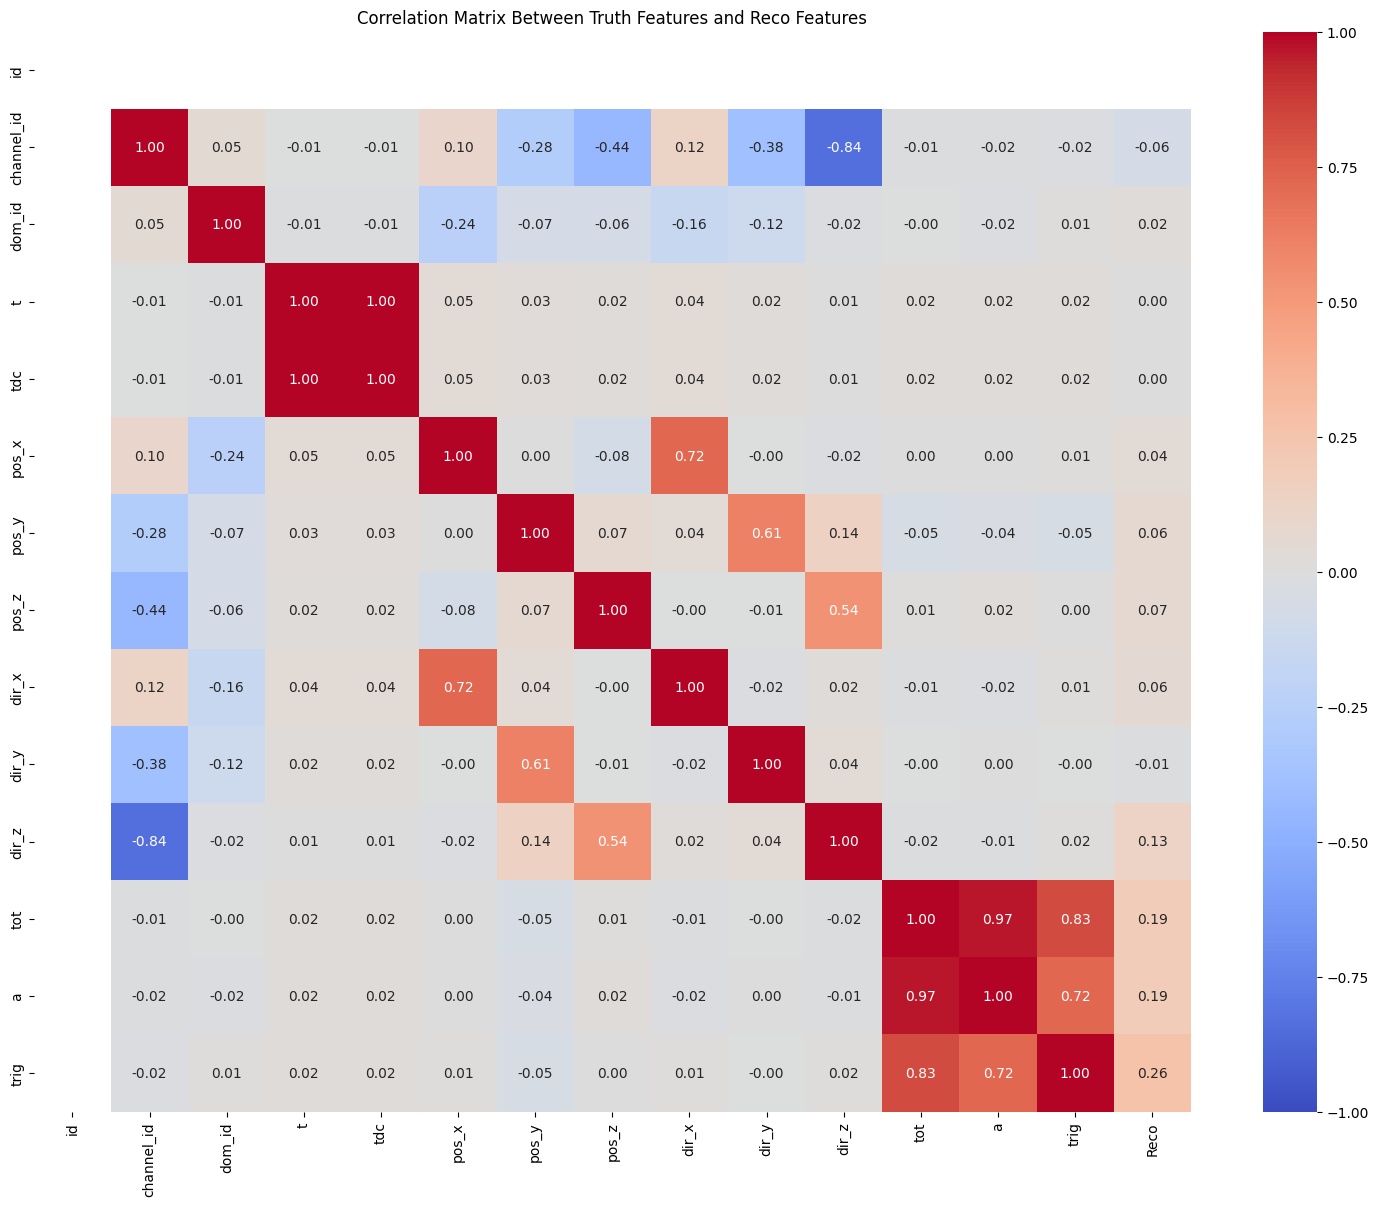

In [20]:
plt.figure(figsize=(15, 12))
sn.heatmap(corr_matrix_truth, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.tight_layout()
plt.title('Correlation Matrix Between Truth Features and Reco Features')
plt.show()

In [21]:
features_df = df_truth
energy_df = df_reco

X = features_df[['dir_z', 'tot', 'a', 'trig']]  #  Without id, id channel, id dim
#X = features_df[['a']]  #  Without id, id channel, id dim
y = energy_df  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

/Users/meskara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [22]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

Model Performance:
MAE: 5736428.547258869
MSE: 190412777911407.4
R2 Score: 0.06447540883084801


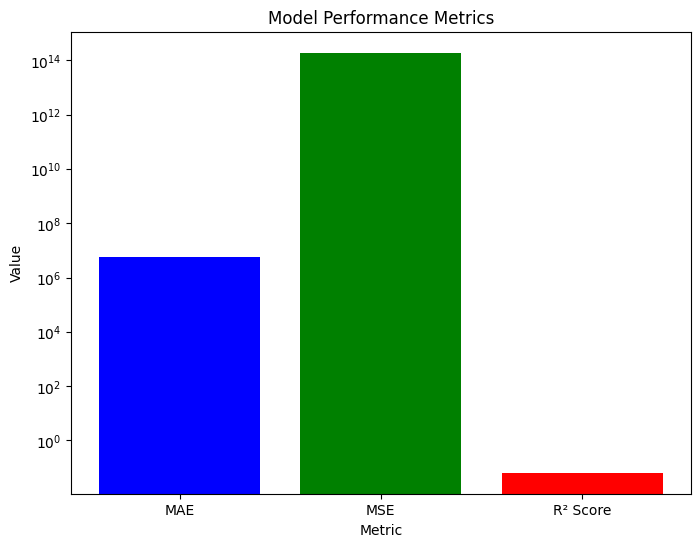

In [23]:
metrics = ['MAE', 'MSE', 'R² Score']
values = [mae, mse, r2]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Model Performance Metrics')
plt.yscale('log')  
plt.show()

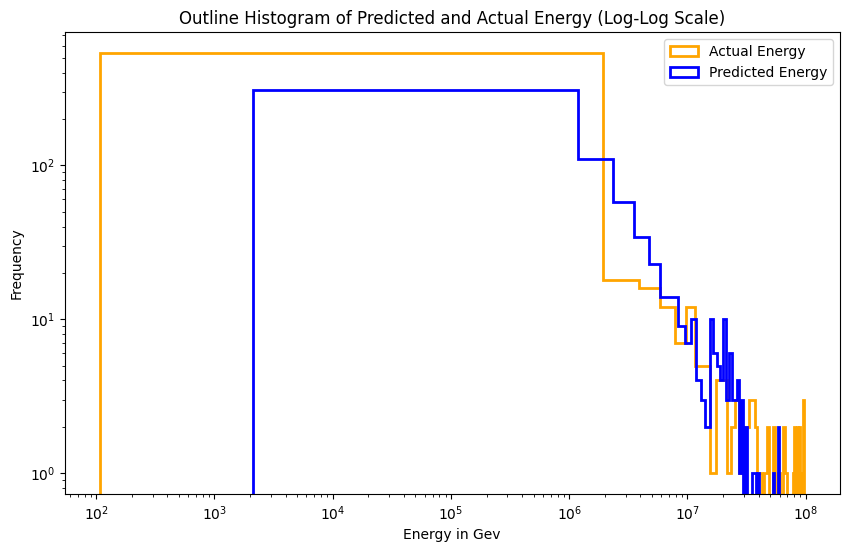

In [24]:
plt.figure(figsize=(10, 6))

plt.hist(y_test, bins=50, histtype='step', color='orange', linewidth=2, label='Actual Energy')
plt.hist(y_pred, bins=50, histtype='step', color='blue', linewidth=2, label='Predicted Energy')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Energy in Gev')
plt.ylabel('Frequency')
plt.title('Outline Histogram of Predicted and Actual Energy (Log-Log Scale)')

plt.legend()

plt.show()